In [40]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vit_b_16, ViT_B_16_Weights
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from PIL import Image
from transformers import ViTFeatureExtractor, ViTModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import plotly.express as px

import os
import shutil

In [41]:
# Scelta modelli
model_a = 'imagenet'
model_b = 'stylegan2'
model_c = 'taming_transformer'
model_d = 'sfhq'

In [42]:
class ImageFolder(Dataset):

    def __init__(self, root_dir, model_a, model_b, model_c, model_d, metadata_name='metadata.csv', nrows=None, transform=None, random_state=42):
        self.root_dir = Path(root_dir)
        self.metadata_name = metadata_name
        self.transform = transform
        self.random_state = random_state
        self.model_a = model_a
        self.model_b = model_b
        self.model_c = model_c
        self.model_d = model_d

        # Carica campioni etichettati 0 e 1
        samples_a = self._load_samples(model_a, label=0, nrows=nrows, real=True)
        samples_b = self._load_samples(model_b, label=1, nrows=nrows)
        samples_c = self._load_samples(model_c, label=2, nrows=nrows)
        samples_d = self._load_samples(model_d, label=3, nrows=nrows)

        print(f"Caricate immagini: '{model_a}': {len(samples_a)} | '{model_b}': {len(samples_b)} | '{model_c}': {len(samples_c)} | '{model_d}': {len(samples_d)}")
        if len(samples_a) == 0 or len(samples_b) == 0 or len(samples_c) == 0 or len(samples_d) == 0:
            raise ValueError(f"Dataset non valido: una delle due classi ha 0 immagini.")

        # Bilancia le classi
        self.samples = self._balance_binary(samples_a + samples_b + samples_c + samples_d)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(self.root_dir / img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def _load_samples(self, folder, label, nrows=None, real = False):
        folder_path = self.root_dir / folder
        meta_file = folder_path / self.metadata_name

        if not meta_file.exists():
            print(f"Metadata file not found for folder: {folder}")
            return []

        df = pd.read_csv(meta_file)

        if not {'image_path', 'target'}.issubset(df.columns):
            print(f"Metadata missing required columns in: {meta_file}")
            return []

        df['target'] = pd.to_numeric(df['target'], errors='coerce')
        df = df[df['target'] > 0]  if not real else df[df['target'] == 0]# Solo immagini valide

        if nrows:
            df = df.sample(n=nrows, random_state=self.random_state)  # Campionamento casuale

        samples = [(Path(folder) / row['image_path'], label) for _, row in df.iterrows()]
        return samples

    def _balance_binary(self, samples):
        # Bilanciamento tramite undersampling
        X = np.arange(len(samples)).reshape(-1, 1)
        y = [label for _, label in samples]
        rus = RandomUnderSampler(random_state=self.random_state)
        X_res, y_res = rus.fit_resample(X, y)
        return [samples[i] for i in X_res.ravel()]


In [43]:
def get_unique_output_dir(model_name, dataset_name=None, test_size=None, base_prefix="svm_results"):
    # Base path: ./Risultati/Model_a_vs_Model_b/
    base_dir = os.path.join("Risultati", model_name)

    # Se dataset è df_reduced, aggiungi PCA
    if dataset_name == "df_reduced":
        prefix = f"{base_prefix}_PCA"
    else:
        prefix = base_prefix

    if test_size is None:
        suffix = "_0"
    else:
        suffix = "_" + str(test_size).replace('.', '_')

    final_path = os.path.join(base_dir, prefix + suffix)

    # Se la cartella esiste, sovrascrivila (elimina tutto il contenuto)
    if os.path.exists(final_path):
        shutil.rmtree(final_path)  # Cancella tutto
    os.makedirs(final_path, exist_ok=True)

    return final_path



def train_SVM(dataset: pd.DataFrame, output_dir: str, val_size=0.1, test_size=0.1):
      

    # Estrai X e y
    X = dataset.drop(columns='label').values
    y_str = dataset['label'].values

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)

    # Split
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42
    )

    print(f"Split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}")

    svc = SVC(class_weight='balanced')
    param_grid = [
        {'kernel': ['linear'],  'C': [0.1, 1, 10]},
        {'kernel': ['rbf'],     'C': [1, 10], 'gamma': ['scale', 0.1]},
        {'kernel': ['sigmoid'], 'C': [1, 10], 'gamma': ['scale', 0.1], 'coef0': [0.0, 0.1, 0.5]}
    ]

    grid = GridSearchCV(
        estimator=svc,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    print(f"Best params from validation: {grid.best_params_}")

    best_svm = SVC(**grid.best_params_, class_weight='balanced')
    best_svm.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

    prediction = best_svm.predict(X_test)

    y_test_labels = label_encoder.inverse_transform(y_test)
    pred_labels = label_encoder.inverse_transform(prediction)

    accuracy = accuracy_score(y_test_labels, pred_labels)
    report = classification_report(y_test_labels, pred_labels)
    cf = confusion_matrix(y_test_labels, pred_labels)

    print(f"Final Test Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{report}")
    print(f"Confusion Matrix:\n{cf}")

    # === SALVATAGGIO FILES ===
    with open(os.path.join(output_dir, "log.txt"), "w") as f:
        f.write(f"Split: Train={len(y_train)}, Val={len(y_val)}, Test={len(y_test)}\n")
        f.write(f"Best params from validation: {grid.best_params_}\n")
        f.write(f"Final Test Accuracy: {accuracy:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(str(cf))

    plot_confusion_matrix(
        cf, class_labels=[model_a, model_b, model_c, model_d],
        save_path=os.path.join(output_dir, "confusion_matrix.png")
    )


def plot_confusion_matrix(cf, class_labels, save_path=None):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    labels = [f"{count}\n({percent})" for count, percent in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(cf.shape)

    plt.figure(figsize=(7, 6))
    sns.set(style="whitegrid")

    ax = sns.heatmap(cf, annot=labels, fmt='', cmap='Blues', cbar=False,
                     xticklabels=class_labels, yticklabels=class_labels)

    ax.set_title("Matrice di Confusione")
    ax.set_xlabel("Classe Predetta")
    ax.set_ylabel("Classe Reale")

    ax.xaxis.set_ticklabels(class_labels, rotation=20)
    ax.yaxis.set_ticklabels(class_labels, rotation=0)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


Caricate immagini: 'imagenet': 10000 | 'stylegan2': 10000 | 'taming_transformer': 10000 | 'sfhq': 10000


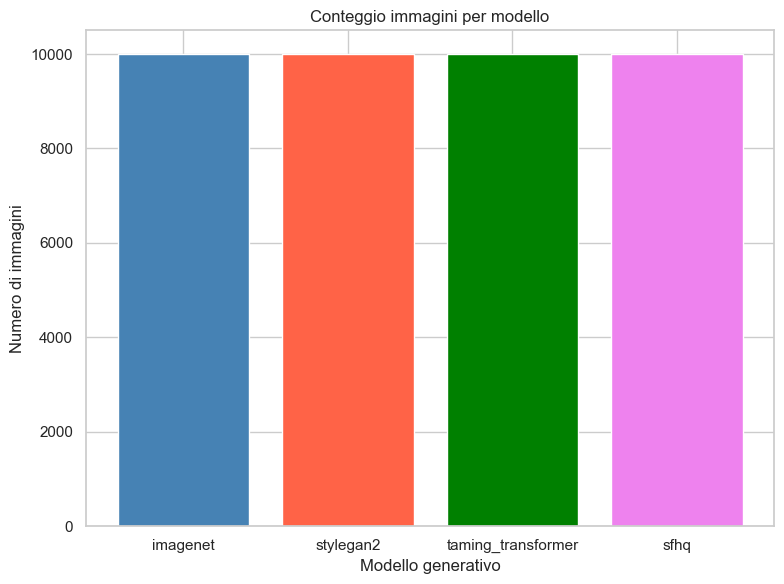

In [44]:
# Trasformazioni standard del modello ViT-B/16
transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

# Caricamento del dataset con label numeriche e trasformazioni
dataset = ImageFolder(
    root_dir='./archive',
    model_a=model_a,
    model_b=model_b,
    model_c=model_c,
    model_d=model_d,
    nrows=10000, 
    transform=transform
)

# DataLoader per batch processing
loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Conversione dei sample in DataFrame
data = pd.DataFrame(dataset.samples, columns=['path', 'label'])

# Mapping esplicito per rendere leggibili le etichette numeriche
label_map = {0: model_a, 1: model_b, 2: model_c, 3: model_d}
data['label_name'] = data['label'].map(label_map)

# Conteggio delle classi
counts = data['label_name'].value_counts().loc[[dataset.model_a, dataset.model_b, dataset.model_c, dataset.model_d]]

# Disegna il plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(counts.index, counts.values, color=['steelblue', 'tomato', 'green', 'violet'])
ax.set_title("Conteggio immagini per modello")
ax.set_xlabel("Modello generativo")
ax.set_ylabel("Numero di immagini")
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

### Estrazione delle features

In [45]:
device = torch.device('cuda')
# Carica il modello ViT-B/16 pre-addestrato
weights = ViT_B_16_Weights.IMAGENET1K_V1
model = vit_b_16(weights=weights)

# Rimuove la testa di classificazione
model.heads.head = nn.Identity()
model.eval().to(device)

all_feats = []
all_labels = []

# Estrazione feature senza gradienti
with torch.no_grad():
    for imgs, labs in tqdm(loader, desc='Processing images', unit='batch'): 
        imgs = imgs.to(device)
        feats = model(imgs)               
        all_feats.append(feats.cpu().numpy())
        all_labels.extend(labs)

# Unione di tutte le feature in un'unica matrice
features = np.vstack(all_feats)
labels = np.array(all_labels)

# Creazione DataFrame finale
feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df = pd.DataFrame(features, columns=feat_cols)
df['label'] = labels

# Salva il DataFrame completo con tutte le feature originali per le operazioni successive come la PCA
feat_cols = [f'feat_{i}' for i in range(features.shape[1])]
df_full = pd.DataFrame(features, columns=feat_cols)
df_full['label'] = labels

# Debug: visualizza numero di esempi per classe
print(df.groupby('label').size())

Processing images: 100%|██████████| 1250/1250 [05:29<00:00,  3.80batch/s]


label
0    10000
1    10000
2    10000
3    10000
dtype: int64


In [46]:
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_759,feat_760,feat_761,feat_762,feat_763,feat_764,feat_765,feat_766,feat_767,label
0,0.490218,-0.074053,-0.308211,-0.306800,0.585756,0.189279,0.211374,0.066335,-0.172358,-0.000059,...,-0.686910,-0.279008,-0.419084,0.037260,-0.286668,0.664624,0.595718,-0.350935,0.080417,0
1,-0.016164,1.309145,0.501369,0.086224,0.633207,0.124615,0.000238,-0.189605,0.079853,0.674614,...,0.116388,0.691713,0.526132,0.238827,-0.021871,0.292651,0.245829,-1.409027,-1.514431,0
2,-1.237997,-0.233254,-0.916307,-1.343566,-0.332993,0.803641,-0.027234,-0.402340,-1.530050,0.912246,...,0.069034,-1.188747,-0.363564,0.399826,-1.049421,0.145601,-0.329979,-0.114937,-2.336844,0
3,0.434760,-0.201733,-0.343258,-0.427284,-0.547516,0.240096,0.024586,-0.065797,1.213986,0.305161,...,-0.040369,0.487795,0.073837,0.241892,-0.502816,0.389852,0.243156,1.001426,-0.017254,0
4,0.792280,-0.026864,-0.353723,0.300600,0.199220,1.293641,0.094108,0.343853,-0.341114,1.025750,...,-0.572695,0.272230,-0.071891,-0.229279,0.146040,0.046576,0.267304,0.697709,-0.098772,0


### Training

Split: Train=31999, Val=4001, Test=4000
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8982
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1000
           1       0.95      0.94      0.94      1000
           2       0.85      0.78      0.81      1000
           3       0.98      0.99      0.98      1000

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000

Confusion Matrix:
[[891  14  95   0]
 [ 10 936  40  14]
 [187  30 778   5]
 [  0   7   5 988]]


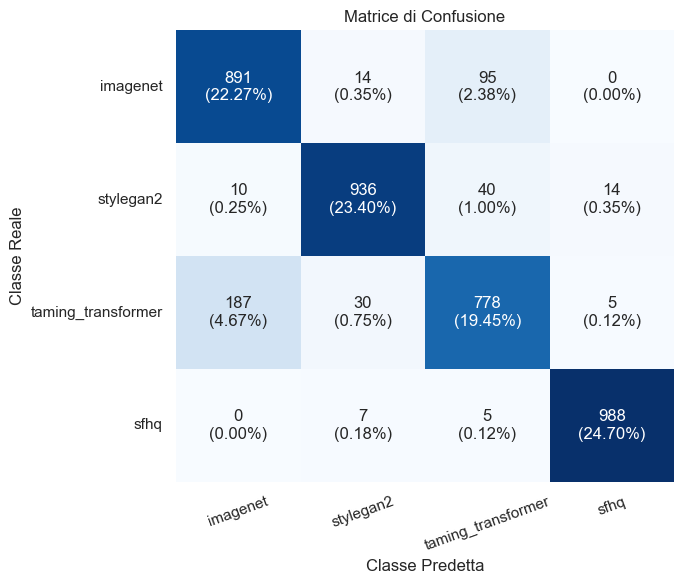

In [47]:
df.__name__ = "df" 

# Crea la stringa nome modelli
model_name = f"{model_a}_vs_{model_b}_vs_{model_c}_vs_{model_d}"

# Crea output_dir
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,test_size=0.1)

# Lancia il training passando output_dir
train_SVM(df, output_dir=output_dir, test_size=0.1)

Split: Train=23999, Val=4001, Test=12000
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8915
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3000
           1       0.94      0.93      0.93      3000
           2       0.83      0.78      0.81      3000
           3       0.98      0.99      0.98      3000

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000

Confusion Matrix:
[[2623   57  319    1]
 [  39 2775  134   52]
 [ 562   76 2342   20]
 [   0   31   11 2958]]


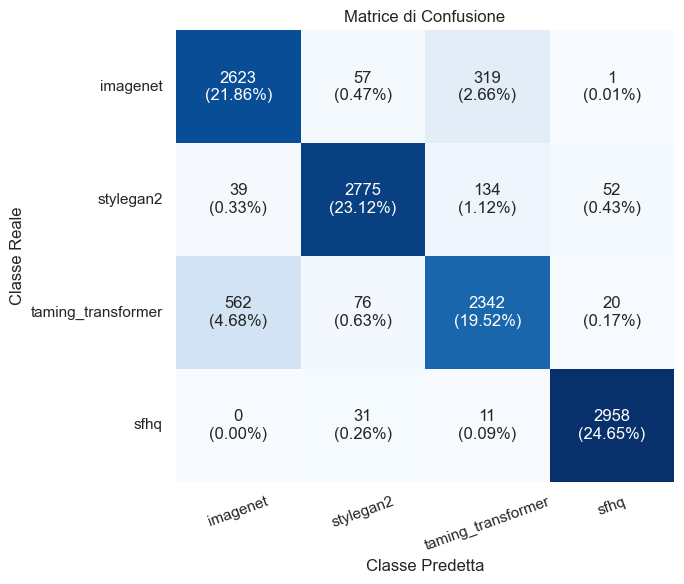

In [48]:
df.__name__ = "df"  

# Crea la stringa nome modelli
model_name = f"{model_a}_vs_{model_b}_vs_{model_c}_vs_{model_d}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,test_size=0.3)

# Lancia il training passando output_dir e test_size
train_SVM(df, output_dir=output_dir, test_size=0.3)


Split: Train=28000, Val=4000, Test=8000
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8948
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2000
           1       0.95      0.93      0.94      2000
           2       0.84      0.78      0.81      2000
           3       0.97      0.99      0.98      2000

    accuracy                           0.89      8000
   macro avg       0.90      0.89      0.89      8000
weighted avg       0.90      0.89      0.89      8000

Confusion Matrix:
[[1751   31  217    1]
 [  19 1861   85   35]
 [ 365   51 1568   16]
 [   0   15    7 1978]]


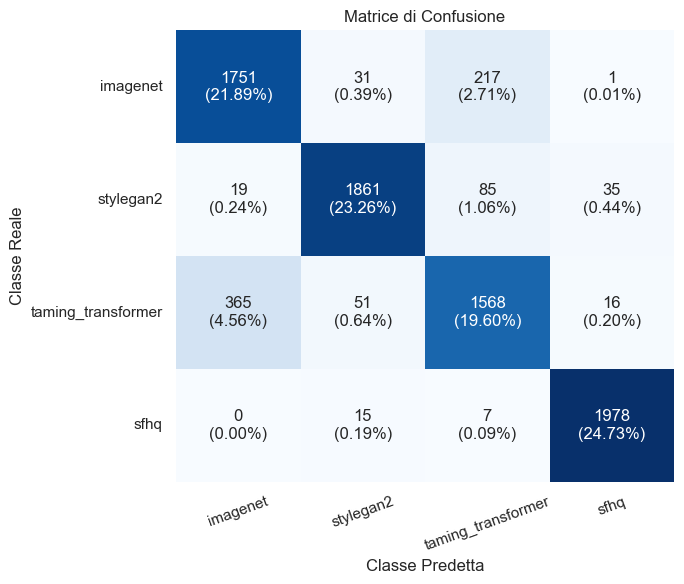

In [49]:
df.__name__ = "df" 

# Crea la stringa nome modelli
model_name = f"{model_a}_vs_{model_b}_vs_{model_c}_vs_{model_d}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,test_size=0.2)

# Lancia il training passando output_dir e test_size
train_SVM(df, output_dir=output_dir, test_size=0.2)


# Riduzione del numero delle features (PCA)

In [50]:
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features)
print(f"Shape dopo PCA: {features_pca.shape}")

Shape dopo PCA: (40000, 3)


In [51]:
# Esempio di dataframe e etichette
df = pd.DataFrame(features_pca, columns=['PC1', 'PC2', 'PC3'])
df['label'] = labels

df['label'] = df['label'].map(label_map)

# Assegna un nome al dataframe (può essere utile per il salvataggio e per la tracciabilità)
df.__name__ = "df_reduced"

# Crea la stringa del nome del modello
model_name = f"{model_a}_vs_{model_b}_vs_{model_c}_vs_{model_d}"

# Crea il grafico 3D con Plotly Express
fig = px.scatter_3d(
    df, x='PC1', y='PC2', z='PC3',
    color='label',  # Coloriamo i punti in base alla colonna 'label'
    title='PCA 3D Visualization',
    opacity=0.7
)

# Personalizzazione della legenda
fig.update_layout(
    legend=dict(
        title="Modelli",
        x=0.8,  # Posizione orizzontale della legenda (80% dalla sinistra)
        y=0.9,  # Posizione verticale della legenda (90% dall'alto)
        bgcolor='rgba(255, 255, 255, 0.5)',  # Sfondo semi-trasparente
        bordercolor='black',  # Colore del bordo della legenda
        borderwidth=2  # Spessore del bordo
    ),
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Mostra il grafico
fig.show()

# Salvataggio del plot 3D in formato HTML
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__)
fig.write_html(os.path.join(output_dir, "pca_3d_plot.html"))


In [52]:
# Seleziona solo le colonne delle feature
feat_cols = [c for c in df_full.columns if c.startswith('feat_')]
X = df_full[feat_cols].values

# Fit completo della PCA per analizzare la varianza cumulativa
pca_full = PCA().fit(X)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Determina quante componenti servono per spiegare almeno il 95% della varianza
n_components = np.argmax(cumvar >= 0.95) + 1
print(f"Numero di componenti per spiegare il 95% della varianza: {n_components}")

# Riduzione dimensionale con il numero ottimale di componenti
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Crea DataFrame con le componenti ridotte
pca_cols = [f'PC{i+1}' for i in range(n_components)]
df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df_full.index)

# Aggiungi le label
df_reduced = pd.concat([df_full[['label']], df_pca], axis=1)

# Visualizza info
print("Shape originale:", df_full.shape)
print("Shape ridotto:", df_reduced.shape)
df_reduced.head()

Numero di componenti per spiegare il 95% della varianza: 574
Shape originale: (40000, 769)
Shape ridotto: (40000, 575)


,label,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC565,PC566,PC567,PC568,PC569,PC570,PC571,PC572,PC573,PC574
0,0,6.180854,0.198802,-0.436454,-0.833927,0.315765,0.645523,-0.043864,-1.754452,1.022501,...,-0.335188,0.428870,-1.006164,0.029925,0.282600,-0.522633,-0.061302,-0.260954,-0.207829,-0.091668
1,0,4.536358,0.422863,-0.768619,-1.028534,0.043003,-0.311459,-1.081900,-2.152951,1.659887,...,-0.028862,-0.116869,-0.348196,0.386743,-0.220923,-0.055648,0.124368,-0.209415,0.195898,-0.041392
2,0,5.014557,1.380280,0.933842,-2.508053,-0.686735,0.300272,-0.685827,-1.321815,0.523450,...,0.159539,-0.036081,-0.259828,-0.610849,-1.087863,0.289763,-0.550916,0.177541,-0.033306,-0.583899
3,0,5.811182,0.336902,0.194629,-0.005749,-0.191386,-0.212795,-0.915236,-1.323854,0.078640,...,0.771993,0.508733,-0.234944,-0.388849,-0.126576,-0.289962,0.359129,0.145727,0.081012,0.029275
4,0,4.675998,0.704684,-1.222023,-0.547557,-0.209763,0.126692,-0.395211,-0.772938,0.765839,...,-0.295306,0.871501,-0.556151,-0.918209,1.302111,0.392299,-0.021804,-0.686752,0.726024,-0.944659


Split: Train=31999, Val=4001, Test=4000
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8920
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.85      1000
           1       0.94      0.93      0.94      1000
           2       0.84      0.77      0.80      1000
           3       0.98      0.99      0.98      1000

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000

Confusion Matrix:
[[881  16 103   0]
 [ 11 932  42  15]
 [193  34 767   6]
 [  0   6   6 988]]


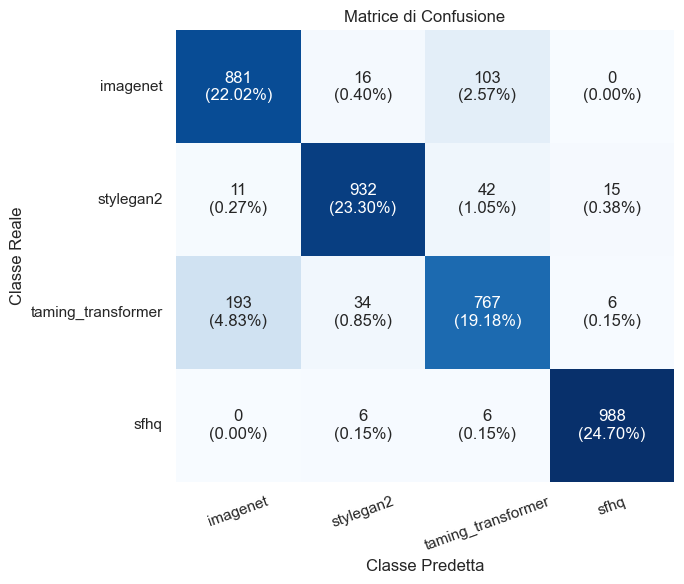

In [53]:
df.__name__ = "df_reduced"

# Crea la stringa nome modelli
model_name = f"{model_a}_vs_{model_b}_vs_{model_c}_vs_{model_d}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__, test_size=0.1)

# Lancia il training passando output_dir e test_size
train_SVM(df_reduced, test_size=0.1, output_dir=output_dir)


Split: Train=23999, Val=4001, Test=12000
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8858
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3000
           1       0.94      0.92      0.93      3000
           2       0.82      0.77      0.79      3000
           3       0.98      0.99      0.98      3000

    accuracy                           0.89     12000
   macro avg       0.89      0.89      0.89     12000
weighted avg       0.89      0.89      0.89     12000

Confusion Matrix:
[[2597   61  341    1]
 [  35 2770  143   52]
 [ 585   91 2303   21]
 [   0   27   13 2960]]


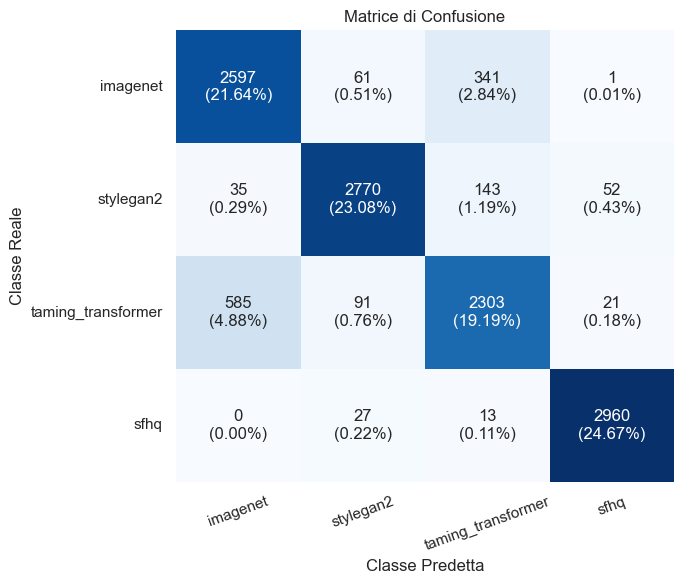

In [54]:
df.__name__ = "df_reduced"

# Crea la stringa nome modelli
model_name = f"{model_a}_vs_{model_b}_vs_{model_c}_vs_{model_d}"


# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,  test_size=0.3)

# Lancia il training passando output_dir e test_size
train_SVM(df_reduced, test_size=0.3, output_dir=output_dir)

Split: Train=28000, Val=4000, Test=8000
Fitting 5 folds for each of 19 candidates, totalling 95 fits
Best params from validation: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Final Test Accuracy: 0.8888
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2000
           1       0.94      0.92      0.93      2000
           2       0.83      0.77      0.80      2000
           3       0.97      0.99      0.98      2000

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000

Confusion Matrix:
[[1744   37  218    1]
 [  18 1846  100   36]
 [ 381   57 1544   18]
 [   0   16    8 1976]]


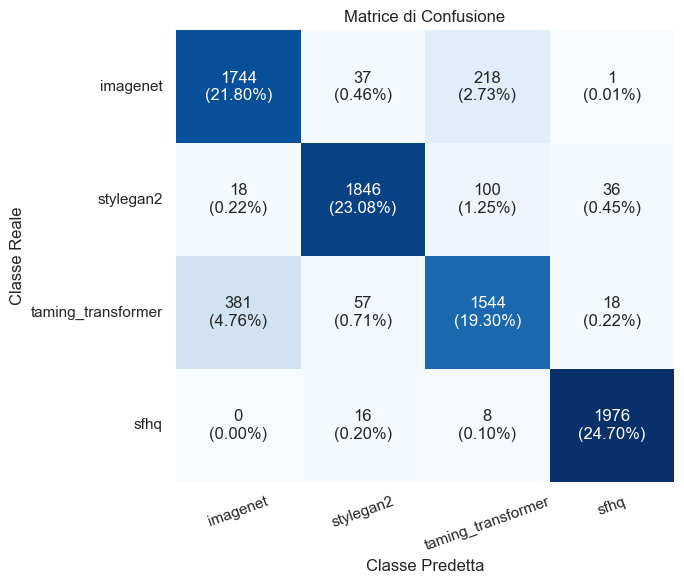

In [55]:
df.__name__ = "df_reduced"

# Crea la stringa nome modelli
model_name = f"{model_a}_vs_{model_b}_vs_{model_c}_vs_{model_d}"

# Crea output_dir con test_size incluso nel nome
output_dir = get_unique_output_dir(model_name=model_name, dataset_name=df.__name__,  test_size=0.2)

# Lancia il training passando output_dir e test_size
train_SVM(df_reduced, test_size=0.2, output_dir=output_dir)